In [1]:
import pandas as pd
import os
import dotenv
dotenv.load_dotenv()

True

In [2]:
neon_db_url = os.environ.get("NEON_DB_CONSTR")

In [3]:
# with pandas, select * from enhanced_price_table from NEONDB where symbol = symbol

# create query select left join where stock_data.stock_id equals select stock_id from stock where symbol = symbol
def get_stock_data(_symbol, _interval, _neon_db_url):
    q = (
         "select {table}.*, stock.symbol, stock.is_relative "
         "from {table} "
         "left join stock on {table}.stock_id = stock.id "
         "where stock.symbol = '{symbol}' "
         "and stock.interval = '{interval}' "
         "{extra}"
    ).format
    
    _stock_data = pd.read_sql(q(table='stock_data', symbol=_symbol, interval=_interval, extra="order by stock_data.bar_number asc"), con=_neon_db_url)
    _regime_data = pd.read_sql(q(table='regime', symbol=_symbol, interval=_interval, extra=""), con=_neon_db_url)
    _peak_data = pd.read_sql(q(table='peak', symbol=_symbol, interval=_interval, extra=""), con=_neon_db_url)
    return _stock_data, _regime_data, _peak_data

def get_data_by_market(_market_index, _interval, _neon_db_url, tables=None):
    if tables is None:
        tables = ['stock_data', 'regime', 'peak']
    q = (
         "select {table}.*, stock.symbol, stock.is_relative "
         "from {table} "
         "left join stock on {table}.stock_id = stock.id "
         "where stock.market_index = '{market}' "
         "and stock.interval = '{interval}' "
         "{extra}"
    ).format
    table_lookup = {
        'stock_data': lambda: pd.read_sql(q(table='stock_data', market=_market_index, interval=_interval, extra="order by stock_data.bar_number asc"), con=_neon_db_url),
        'regime': lambda: pd.read_sql(q(table='regime', market=_market_index, interval=_interval, extra=""), con=_neon_db_url),
        'peak': lambda: pd.read_sql(q(table='peak', market=_market_index, interval=_interval, extra=""), con=_neon_db_url)
    }
    result = [table_lookup[table]() for table in tables]
    return result

def aggregate_regime(_regime_table, by_regime=None):
    regime_types = _regime_table.type.unique()
    if by_regime is None:
        by_regime = regime_types
    # else throw error if by_regime not in regime_types
    elif not set(by_regime).issubset(set(regime_types)):
        raise ValueError(f"by_regime must be a subset of {regime_types}")

    # new df set index using start and end cols of spy_regime as range
    rg_long_table = pd.DataFrame(
        index=pd.RangeIndex(start=_regime_table.start.min(), stop=_regime_table.end.max(), step=1))
    # for each unique symbol in spy_regime, create a new column in spy_rg
    for _symbol in _regime_table.symbol.unique():
        rgs = _regime_table.loc[_regime_table.symbol == _symbol].copy()
        symbol_rg = rg_long_table.copy()
        for index, row in rgs.iterrows():
            symbol_rg.loc[row.start:row.end, row.type] = row.rg
        # aggregate rg_types by mean
        rg_long_table[_symbol] = symbol_rg[by_regime].mean(axis=1)
    
    return rg_long_table

In [4]:
# graph regime for all SPY sector etfs
(spy_regime,) = get_data_by_market('SPY', '1d', neon_db_url, tables=['regime'])
# drop ONEQ as it is not a sector etf

spy, _, __ = get_stock_data('SPY', '1d', neon_db_url)
spy.index = spy.bar_number
spy.index.name = 'index'


<AxesSubplot:title={'center':'Relative Regime Counts'}>

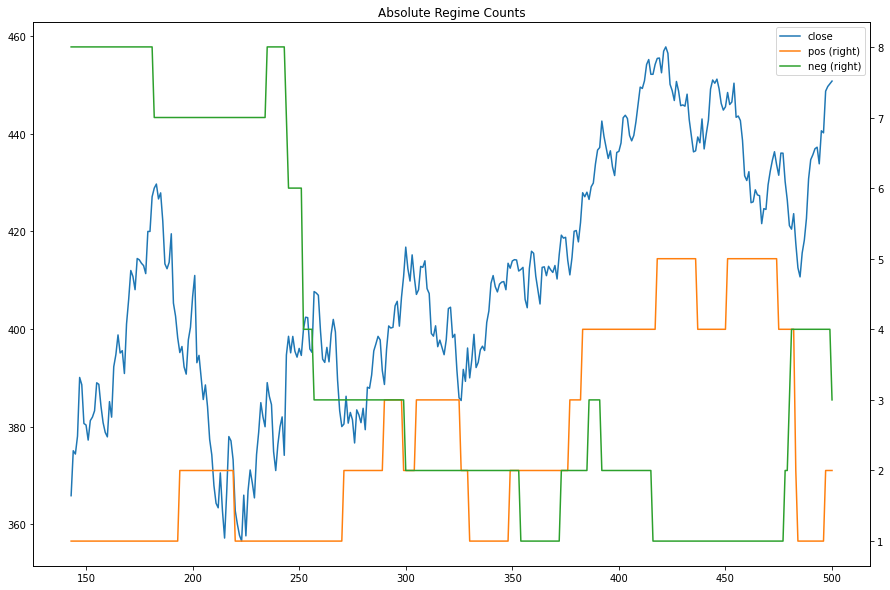

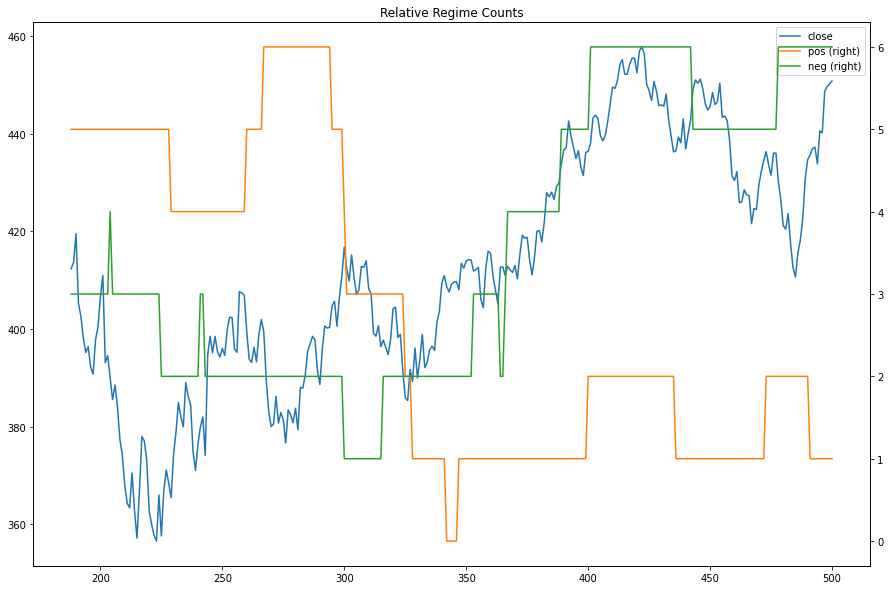

In [5]:
pos_counter = lambda x: x == 1
neg_counter = lambda x: x == -1
spy_regime = spy_regime.loc[spy_regime.symbol != 'ONEQ'].copy()

abs_agg_regimes = aggregate_regime(spy_regime.loc[spy_regime.is_relative == False].copy()).dropna()
abs_regime_counts = pd.DataFrame({
    'pos': abs_agg_regimes.apply(pos_counter).sum(axis=1),
    'neg': abs_agg_regimes.apply(neg_counter).sum(axis=1)
})
# merge counts on spy where count index = spy.bar_number
abs_spy = spy.loc[spy.is_relative == False].copy()
# set index to bar_number
abs_spy.set_index('bar_number', inplace=True)
# merge counts with spy on index
abs_regime_counts = abs_spy[['close']].merge(abs_regime_counts, left_index=True, right_index=True)
# plot
abs_regime_counts.plot(figsize=(15, 10), secondary_y=['neg', 'pos'], title='Absolute Regime Counts')
rel_agg_regimes = aggregate_regime(spy_regime.loc[spy_regime.is_relative == True].copy()).dropna()

rel_agg_regime_count = pd.DataFrame({
    'pos': rel_agg_regimes.apply(pos_counter).sum(axis=1),
    'neg': rel_agg_regimes.apply(neg_counter).sum(axis=1)
})
rel_regime_counts = abs_spy[['close']].merge(rel_agg_regime_count, left_index=True, right_index=True)
rel_regime_counts.plot(figsize=(15, 10), secondary_y=['neg', 'pos'], title='Relative Regime Counts')

In [6]:
# current scoreboard (current values) of aggregate regime in absolute, relative as one dataframe
current_regime = pd.DataFrame({
    'abs': abs_agg_regimes.iloc[-1],
    'rel': rel_agg_regimes.iloc[-1]
})

current_regime

,abs,rel
XLE,1.000000,0.5
XLF,-0.500000,-1.0
XLU,-1.000000,-1.0
XLI,-0.500000,-1.0
XLK,1.000000,1.0
XLV,-1.000000,-1.0
XLY,0.333333,0.0
XLP,-1.000000,-1.0
XLB,-0.500000,-1.0


In [7]:
import src.position_calculation as pc
# stop = 451.64
# cost = 448.66
# fraction = 2/3
# pc.TwoLegTradeEquation.Solve.price(stop, cost, fraction)
# pc.PositionSize.Solve.quantity(stop, cost, 1000)
# select peak rows with the highest peak.start and peak.lvl = 2 for all stock_id in peak
peaks_by_latest_regime = pd.read_sql(
"""
SELECT 
    p.*
FROM 
    peak p
JOIN (
    SELECT 
        r1.stock_id,
        r1.rg,
        r1.start
    FROM 
        regime r1
    JOIN (
        SELECT 
            stock_id,
            MAX(start) AS max_start
        FROM 
            regime
        WHERE 
            type = 'fc'
        GROUP BY 
            stock_id
    ) AS r2 ON r1.stock_id = r2.stock_id AND r1.start = r2.max_start
) AS latest_regime
ON 
    p.stock_id = latest_regime.stock_id 
    AND p.type = latest_regime.rg
WHERE 
    p.start > latest_regime.start
    and p.lvl = 2

""",
    con=neon_db_url
)
stock = pd.read_sql("select * from stock", con=neon_db_url)



In [8]:
# select rows where peaks_by_latest_regime.start is max for each stock_id in peaks_by_latest_regime
latest_lvl2_peaks = peaks_by_latest_regime.loc[peaks_by_latest_regime.groupby('stock_id').start.idxmax()].copy()
# get cost of each stock_id

In [9]:
cost = pd.read_sql(
"""
SELECT 
    stock_id,
    bar_number,
    close
FROM (
    SELECT 
        stock_id,
        bar_number,
        close,
        ROW_NUMBER() OVER (PARTITION BY stock_id ORDER BY bar_number DESC) AS rn
    FROM 
        stock_data
) AS ranked
WHERE 
    rn = 1;
"""
, con=neon_db_url)

In [20]:

import src.position_calculation as pc
import numpy as np
import sympy as sp

# merge latest_lvl2_peaks with cost on stock_id
entry_data = latest_lvl2_peaks.merge(cost, on='stock_id').rename(columns={'st_px': 'stop', 'close': 'cost'})
entry_data['fraction'] = 2/3
symbols = [pc.TwoLegTradeEquation.S, pc.TwoLegTradeEquation.C, pc.TwoLegTradeEquation.F]
v_price = sp.lambdify(
    symbols, 
    pc.TwoLegTradeEquation.solve_for_P,
    "numpy"
)
entry_data['target'] = v_price(entry_data.stop, entry_data.cost, 2/3)
# merge stock with entry_data on id, stock_id
full_entry_data = entry_data.merge(stock[['id', 'is_relative', 'symbol', 'data_source', 'sec_type']], left_on='stock_id', right_on='id')
full_entry_data = full_entry_data.loc[
    (full_entry_data.is_relative == False) & 
    (full_entry_data.data_source != 'yahoo') &
    (full_entry_data.sec_type != 'IND')
].copy()


In [21]:
full_entry_data['r_pct'] = ((full_entry_data.cost - full_entry_data.stop) / full_entry_data.cost) * full_entry_data['type']
# sort full_entry_data ascending r_pct
full_entry_data.sort_values('r_pct', inplace=True)

In [25]:
stop = 76.49
cost = 85
fraction = 3/4
print('Target: ', pc.TwoLegTradeEquation.Solve.price(stop, cost, fraction))
print('Quantity: ', pc.PositionSize.Solve.quantity(stop, cost, 1000))

Target:  87.8366666666667
Quantity:  117.508813160987
